In [10]:
import numpy as np
import tensorflow_probability as tfp 
import tensorflow
import matplotlib.pyplot as plt


#See:
#https://www.youtube.com/watch?v=dxwVMeK988Y&list=PLISXH-iEM4JloWnKysIEPPysGVg4v3PaP&index=6&ab_channel=MachineLearning%26Simulation


'\nSee:\nhttps://www.youtube.com/watch?v=dxwVMeK988Y&list=PLISXH-iEM4JloWnKysIEPPysGVg4v3PaP&index=6&ab_channel=MachineLearning%26Simulation\n\n'

Text(0.5, 1.0, 'Samples of X~N(mu_true, sigma_true), ie the dataset')

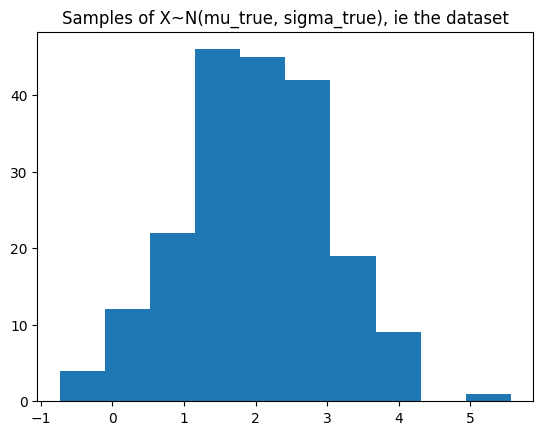

In [60]:
# Create a true latent random variable. These would most likely be unknowned to us in practice
mu_true  = 2
sigma_true = 1
N = 200

X = tfp.distributions.Normal(loc=mu_true, scale=sigma_true)
# Sample some data
dataset = X.sample(N)


_ = plt.hist(dataset)
plt.title('Samples of X~N(mu_true, sigma_true), ie the dataset')

In [52]:
# Calculate True posterior of mu. These are only tractable in special cases. In this case we have that the prior and posterior are conjugate distributions
# Thus we get the following formulas

# Prior guess of mu ~ N(m0, s0)
m0 = 1.7
s0 = 0.5


mu_N = (sigma_true**2 * m0 + s0**2 * tf.reduce_sum(dataset)) / (sigma_true**2 + N*s0**2)
sigma_N = (s0 * sigma_true) / tf.sqrt(sigma_true**2 + N * s0**2)

print(mu_N, sigma_N)



tf.Tensor(1.9919575, shape=(), dtype=float32) tf.Tensor(0.07001401, shape=(), dtype=float32)


For variational inference we need: Log-joint and Surrogate

In [53]:
# We

def generative_model(m0, s0, sigma, n_samples):
    # mu ~ N(m0, s0)
    # X ~  N(mu, sigma) , # ie sigma is known

    # Root: Wrapper for coroutine distributions which lack distribution parents.
    # JointDistributionCoroutine: This distribution enables both sampling and joint probability computation from a single model specification.
    mu = yield tfp.distributions.JointDistributionCoroutine.Root(tfp.distributions.Normal(loc=m0, scale=s0, name='mu'))
    # We yield a batch of n_samples
    X =  yield tfp.distributions.Normal(loc=mu * tf.ones(n_samples), scale=sigma, name='X')

# JointDistributionCoroutineAutoBatched :This class provides automatic vectorization and alternative semantics for 
#   tfd.JointDistributionCoroutine, which in many cases allows for simplifications in the model specification.
#   Takes a model as an argument

model_joint = tfp.distributions.JointDistributionCoroutineAutoBatched(lambda: generative_model(m0, s0, sigma_true, N))


Text(0.5, 1.0, 'samples of X~N(mu, sigma), given, mu = N(m0, s0)')

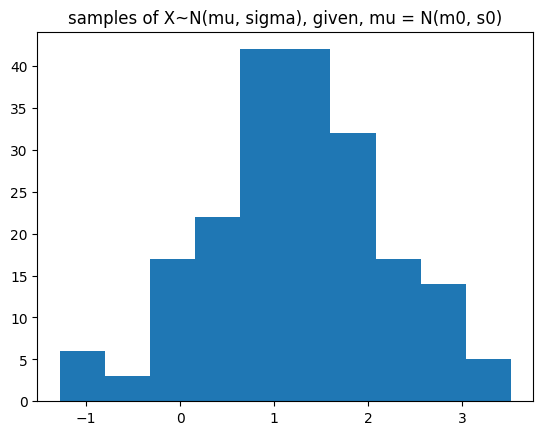

In [59]:
sample = model_joint.sample()
plt.hist(sample[1])

plt.title('samples of X~N(mu, sigma), given, mu = N(m0, s0)')

Text(0.5, 1.0, 'model_joint_logprob')

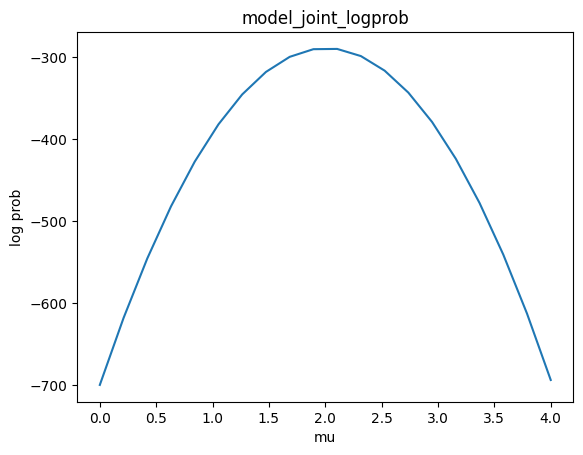

In [71]:

# How likely is it that a given mu represents the mu that underlies the data
model_joint_logprob = lambda mu: model_joint.log_prob(mu, dataset)

x = np.linspace(0,4,20)
y = [model_joint_logprob(i) for i in x]

plt.plot(x,y)
plt.xlabel('mu')
plt.ylabel('log prob')
plt.title('model_joint_logprob')


# Surrogate posterior

In [74]:
# Start by defining learnable parameters

mu_S = tf.Variable(m0, name='mu surrogate')
# Since we have the constraint that sigma_S has to be >= 0 we need to use Softplus.
sigma_S = tfp.util.TransformedVariable(s0, name='sigma surrogate', bijector=tfp.bijectors.Softplus()) 

model_surrogate_posterior = tfp.distributions.Normal(loc=mu_S, scale=sigma_S, name='surrogate_post')

model_surrogate_posterior

<tfp.distributions.Normal 'surrogate_post' batch_shape=[] event_shape=[] dtype=float32>

In [77]:
model_surrogate_posterior.trainable_variables

(<tf.Variable 'mu surrogate:0' shape=() dtype=float32, numpy=1.7>,
 <tf.Variable 'sigma surrogate:0' shape=() dtype=float32, numpy=-0.43275213>)

In [78]:
# In above its shown as its untransformed version
sigma_S

<TransformedVariable: dtype=float32, shape=[], fn="softplus", numpy=0.5>

In [81]:
model_surrogate_posterior.sample(3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.1577902, 1.1176131, 1.9327567], dtype=float32)>

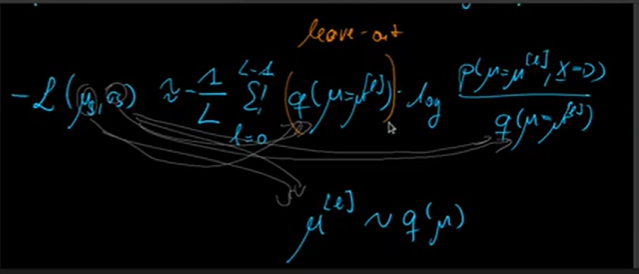

In [83]:
model_joint_logprob.sample(3)

AttributeError: 'function' object has no attribute 'sample'

In [84]:
n_samples = 3
with tf.GradientTape() as g:
    samples = model_surrogate_posterior.sample(n_samples)
    neg_elbo = - tf.reduce_mean(model_joint_logprob(samples) - model_surrogate_posterior.log_prob(samples))  # log täljare - log nämnare

In [85]:
neg_elbo

<tf.Tensor: shape=(), dtype=float32, numpy=330.287>

In [86]:
g.gradient(neg_elbo, model_surrogate_posterior.trainable_variables)

(<tf.Tensor: shape=(), dtype=float32, numpy=-49.15693>,
 <tf.Tensor: shape=(), dtype=float32, numpy=54.008553>)

In [90]:
lr = 0.1
num_steps = 1000
sample_size = 100
tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model_joint_logprob,
    surrogate_posterior=model_surrogate_posterior,
    optimizer=tf.optimizers.Adam(lr),
    num_steps=num_steps,
    sample_size=sample_size)

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([290.61707, 291.5932 , 290.63977, 290.7319 , 291.03085, 291.08228,
       290.6287 , 290.6077 , 290.71466, 290.88605, 290.8765 , 290.6986 ,
       290.5886 , 290.62894, 290.64578, 290.72208, 290.60336, 290.61667,
       290.6143 , 290.59872, 290.61807, 290.64233, 290.64404, 290.66876,
       290.60785, 290.61038, 290.6404 , 290.64017, 290.62482, 290.64066,
       290.608  , 290.60355, 290.6443 , 290.6514 , 290.60873, 290.62036,
       290.60388, 290.6149 , 290.61264, 290.61163, 290.59656, 290.6117 ,
       290.70978, 290.63153, 290.59656, 290.65497, 290.64062, 290.60968,
       290.6242 , 290.62582, 290.6104 , 290.61102, 290.60013, 290.62445,
       290.6409 , 290.6373 , 290.60602, 290.60962, 290.6917 , 290.6068 ,
       290.60278, 290.61066, 290.60742, 290.60202, 290.59833, 290.623  ,
       290.61884, 290.61716, 290.6246 , 290.60397, 290.61877, 290.6056 ,
       290.60364, 290.64972, 290.62173, 290.60208, 290.6086 , 290.631  ,
  

In [91]:
mu_S

<tf.Variable 'mu surrogate:0' shape=() dtype=float32, numpy=2.0051258>

In [92]:
sigma_S

<TransformedVariable: dtype=float32, shape=[], fn="softplus", numpy=0.07647524>

In [94]:
sigma_N

<tf.Tensor: shape=(), dtype=float32, numpy=0.07001401>

In [95]:
mu_N

<tf.Tensor: shape=(), dtype=float32, numpy=1.9919575>

In [97]:
mu_true

2

In [98]:
sigma_true

1